In [1]:
import pandas as pd
import csv
import time
import numpy as np
import re
import os

import sys
sys.path.insert(0, '../')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

import collections
from collections import defaultdict

import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
stemmer = PorterStemmer()
import gensim
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import plotly
import plotly.graph_objs as go


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### STS benchmark

In [2]:
col_names=['genre', 'file', 'year', 'feature_1','feature_2', 'sentence_1', 'sentence_2', 'feature_3','feature_4']

df_train_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-train.xls', header=None, names=col_names)
df_train_sts["sent1_length"]= df_train_sts["sentence_1"].str.len()
df_train_sts["sent2_length"]= df_train_sts["sentence_2"].str.len()

df_test_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-test.xls', header=None, names=col_names)
df_test_sts["sent1_length"]= df_test_sts["sentence_1"].str.len()
df_test_sts["sent2_length"]= df_test_sts["sentence_2"].str.len()

df_dev_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-dev.xls', header=None, names=col_names)
df_dev_sts["sent1_length"]= df_dev_sts["sentence_1"].str.len()
df_dev_sts["sent2_length"]= df_dev_sts["sentence_2"].str.len()

df_sts=pd.concat([df_train_sts, df_test_sts, df_dev_sts])

In [3]:
print ('The lenght of the train dataset is :', df_train_sts.shape)
print ('The lenght of the test dataset is :', df_test_sts.shape)
print ('The lenght of the dev dataset is :', df_dev_sts.shape)
print ('The lenght of the total dataset is :', df_sts.shape)

The lenght of the train dataset is : (5749, 11)
The lenght of the test dataset is : (1379, 11)
The lenght of the dev dataset is : (1500, 11)
The lenght of the total dataset is : (8628, 11)


### SICK benchmark

In [4]:
df_sick = pd.read_csv("/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/SICK/SICK.txt", sep='\t')

In [5]:
df_sick=df_sick.drop('sentence_B_original', axis=1)

In [6]:
df_test_sick=df_sick.loc[df_sick['SemEval_set']=='TEST']
df_train_sick=df_sick.loc[df_sick['SemEval_set']=='TRAIN']
df_trial_sick=df_sick.loc[df_sick['SemEval_set']=='TRIAL']

In [7]:
print ('The lenght of the train dataset is :', df_train_sick.shape)
print ('The lenght of the test dataset is :', df_test_sick.shape)
print ('The lenght of the dev dataset is :', df_trial_sick.shape)
print ('The lenght of the total dataset is :', df_sick.shape)

The lenght of the train dataset is : (4439, 11)
The lenght of the test dataset is : (4906, 11)
The lenght of the dev dataset is : (495, 11)
The lenght of the total dataset is : (9840, 11)


#### Lets try to have a balance dataset for both database, therefore we will establish: 
- train: 6000 sentences
- test: 2500 sentences 
- trial: 500 sentences

In [8]:
df_test_sts=pd.concat([df_dev_sts[0:700], df_test_sts])


In [9]:
df_train_sts=pd.concat([df_dev_sts[700:1000], df_train_sts])

In [10]:
df_dev_sts=df_dev_sts[1000:]

In [11]:
print ('The lenght of the train dataset is :', df_train_sts.shape)
print ('The lenght of the test dataset is :', df_test_sts.shape)
print ('The lenght of the dev dataset is :', df_dev_sts.shape)
print ('The lenght of the total dataset is :', df_sts.shape)

The lenght of the train dataset is : (6049, 11)
The lenght of the test dataset is : (2079, 11)
The lenght of the dev dataset is : (500, 11)
The lenght of the total dataset is : (8628, 11)


In [12]:
df_train_sick=pd.concat([df_test_sick[0:1700], df_train_sick])

In [216]:
df_train_sick

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_A_dataset,sentence_B_dataset,SemEval_set
5,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.300,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TEST
6,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,NEUTRAL,3.700,A_neutral_B,B_neutral_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST
7,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,NEUTRAL,3.000,A_neutral_B,B_contradicts_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST
9,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,ENTAILMENT,4.900,A_entails_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST
10,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,NEUTRAL,3.665,A_neutral_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST
...,...,...,...,...,...,...,...,...,...,...,...
9832,9993,A door is being opened by a man,A bald man in a band is playing guitar in the ...,NEUTRAL,1.100,A_neutral_B,B_neutral_A,a man is opening a door,SEMEVAL,FLICKR,TRAIN
9836,9997,Someone is boiling okra in a pot,The man is not playing the drums,NEUTRAL,1.000,A_neutral_B,B_neutral_A,someone is boiling okra in a pot,SEMEVAL,SEMEVAL,TRAIN
9837,9998,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...,NEUTRAL,1.000,A_neutral_B,B_neutral_A,the man sang and played his guitar,SEMEVAL,FLICKR,TRAIN
9838,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,NEUTRAL,1.200,A_neutral_B,B_neutral_A,a man is jumping rope outside,SEMEVAL,FLICKR,TRAIN


In [13]:
df_test_sick=df_test_sick[2000:4000]

In [14]:
print ('The lenght of the train dataset is :', df_train_sick.shape)
print ('The lenght of the test dataset is :', df_test_sick.shape)
print ('The lenght of the dev dataset is :', df_trial_sick.shape)
print ('The lenght of the total dataset is :', df_sick.shape)

The lenght of the train dataset is : (6139, 11)
The lenght of the test dataset is : (2000, 11)
The lenght of the dev dataset is : (495, 11)
The lenght of the total dataset is : (9840, 11)


### Data Preprocessing

In [15]:
STOP_WORDS = nltk.corpus.stopwords.words()
 

In [16]:
def clean_sentence(val):
    #regex = re.compile('([^\s\w]|_)+')
    sentence = val.lower()
    sentence = sentence.split(" ")
   
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word) 
            
    sentence = " ".join(sentence)
    return sentence

In [17]:
def clean_dataframe(data, colum):
    df=pd.DataFrame()

    df=pd.concat([df_train_sick['sentence_A'], df_train_sick['sentence_B']]).reset_index()
    
    df.columns=['index','sent']
    
    df = df.dropna(how="any")
   
    for col in [colum]:
        df['sentence_clean'] = df[col].apply(clean_sentence)
        df['sentence_clean'].replace(" ", "_")
   
    return df
 

In [18]:
def clean_dataframe_2(df, colum):
  
    
    df = df.dropna(how="any")
   
    for col in df['sentence_A']:
        df['sentence_clean'] = df['sentence_A'].apply(clean_sentence)
   
    return df
 

In [19]:
df = df_train_sick.dropna(how="any")
   


In [20]:
def create_data_sent(df, colum):
    
    df = df.dropna(how="any")
    
    list_sentence=[]

    #regex = re.compile('([^\s\w]|_)+')
    for val in  df[colum]:
        sentence = val.lower()
        sentence = sentence.split(" ")

        for word in list(sentence):
            if word in STOP_WORDS:
                sentence.remove(word) 

        sentence = " ".join(sentence)
        list_sentence.append(sentence)
        
    print(len(list_sentence))
    df['sentence_clean']=list_sentence
    
    return df

In [21]:
data_A= create_data_sent(df_train_sick,'sentence_A')

6139


In [22]:
data_B= create_data_sent(df_train_sick,'sentence_B')

6139


In [23]:
data=clean_dataframe(df_train_sts,'sent')

In [217]:
len(data)

12278

In [24]:
len(data['sent'].unique())

5265

In [25]:
def build_corpus(data, colum):
    corpus = []
    for col in [colum]:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
           
    return corpus

In [26]:
corpus=build_corpus(data, 'sentence_clean')

In [27]:
len(corpus)

12278

### Apply model 

In [28]:
model = word2vec.Word2Vec(corpus, size=100, min_count=1, workers=4)

In [29]:
model.train(corpus, total_examples=model.corpus_count, epochs=30, report_delay=1)

(1261591, 1589430)

In [30]:
vocab=model.wv.vocab

In [272]:
len(vocab)

2286

### Obtain the vector per sentence

In [31]:
def get_dict_corpus(vocab, model):
    
    
    dict_word_2_vect={}
    dict_corpus_2_vect={}

    ## create the dictionary of the words and its vector 
    for idx, key in enumerate(vocab):
        dict_word_2_vect[key]=model.wv.get_vector(key)
        
   ## create the dictionary for the corpus and its vector  
    for elem in corpus: 
        list_prod_elem=[]
        for ele in elem:
            if ele in dict_word_2_vect: 
                vector_ele=dict_word_2_vect[ele]
                list_prod_elem.append(vector_ele)
            dict_corpus_2_vect[tuple(elem)]=list_prod_elem

    return dict_corpus_2_vect

In [32]:
dict_corpus_2_vect=get_dict_corpus(vocab,model)

In [271]:
len(dict_corpus_2_vect)

4220

In [33]:
def get_vector_sentence(dict_corpus_2_vect):
    
    dict_corpus_2_mean={}
    sumOfNumbers = 0

    for k ,v in dict_corpus_2_vect.items():
        for vec in v:
            sumOfNumbers = sumOfNumbers + vec

        avg = sumOfNumbers / len(v)
        dict_corpus_2_mean[k]=[avg]
        
    return dict_corpus_2_mean

In [34]:
dict_corpus_2_mean=get_vector_sentence(dict_corpus_2_vect)

In [270]:
len(dict_corpus_2_mean)

4220

In [267]:
df=pd.DataFrame.from_dict(dict_corpus_2_mean, orient='index').reset_index()
df.columns=['sentence_clean','mean_vector_B']

In [269]:
data_B

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_A_dataset,sentence_B_dataset,SemEval_set,sentence_clean
5,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.300,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TEST,group kids playing yard old standing background
6,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,NEUTRAL,3.700,A_neutral_B,B_neutral_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST,young boys playing outdoors smiling nearby
7,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,NEUTRAL,3.000,A_neutral_B,B_contradicts_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST,young boys playing outdoors smiling nearby
9,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,ENTAILMENT,4.900,A_entails_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST,brown attacking another animal front pants
10,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,NEUTRAL,3.665,A_neutral_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST,brown helping another animal front pants
...,...,...,...,...,...,...,...,...,...,...,...,...
9832,9993,A door is being opened by a man,A bald man in a band is playing guitar in the ...,NEUTRAL,1.100,A_neutral_B,B_neutral_A,a man is opening a door,SEMEVAL,FLICKR,TRAIN,bald band playing guitar spotlight
9836,9997,Someone is boiling okra in a pot,The man is not playing the drums,NEUTRAL,1.000,A_neutral_B,B_neutral_A,someone is boiling okra in a pot,SEMEVAL,SEMEVAL,TRAIN,playing drums
9837,9998,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...,NEUTRAL,1.000,A_neutral_B,B_neutral_A,the man sang and played his guitar,SEMEVAL,FLICKR,TRAIN,bicyclist holding bike head group people
9838,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,NEUTRAL,1.200,A_neutral_B,B_neutral_A,a man is jumping rope outside,SEMEVAL,FLICKR,TRAIN,jumping rope outside


In [268]:
df

,sentence_clean,mean_vector_B
0,"(boy, playing, outdoors, smiling)","[0.43800917, 0.1974906, 0.007307589, 0.0369084..."
1,"(group, boys, yard, playing, standing, backgro...","[0.6727627, -0.17696868, 0.2732952, -0.0158735..."
2,"(group, children, playing, house, standing, ba...","[0.9565664, -0.49428, 0.42250443, -0.31214368,..."
3,"(brown, attacking, another, animal, front, tal...","[0.7488106, -0.7272957, 0.5976925, 0.20432244,..."
4,"(brown, attacking, another, animal, front, pants)","[0.76807433, -1.1486329, 0.8961909, 0.741039, ..."
...,...,...
4215,"(black, brown, eyeing, insect)","[689.3677, 118.080574, 1220.4855, 354.57785, 1..."
4216,"(stopping, middle, road)","[919.2923, 156.89442, 1627.2656, 472.73978, 20..."
4217,"(standing, dirt, hill, next, black, car)","[459.36526, 77.974686, 814.07886, 237.14606, 1..."
4218,"(rollerblader, performing, trick, ramp)","[689.1997, 117.244705, 1220.027, 355.71048, 15..."


In [262]:
def obtain_final_df(clean_data,  dict_corpus_2_mean , sentence, mean_name):
    
    df=pd.DataFrame.from_dict(dict_corpus_2_mean, orient='index').reset_index()
    df.columns=['sentence_clean',mean_name]
    
    for idx, row in df.iterrows():
           row['sentence_clean'] =' '.join(row['sentence_clean'])

    df_merge=pd.concat([clean_data,df], axis=1)
    
    return df_merge

In [37]:
df_A= obtain_final_df(data_A,  dict_corpus_2_mean, 'sentence_A', 'mean_vector_A')

In [218]:
len(df_A)

6139

In [38]:
df_A=df_A.rename(columns={"sentence_clean": "sentence_clean_A"})

In [263]:
df_B= obtain_final_df(data_B ,  dict_corpus_2_mean, 'sentence_B', 'mean_vector_B')

In [265]:
df_B.dropna()

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_A_dataset,sentence_B_dataset,SemEval_set,sentence_clean,sentence_clean,mean_vector_B
0,1.0,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,NEUTRAL,4.5,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN,group boys yard playing standing background,boy playing outdoors smiling,"[0.43800917, 0.1974906, 0.007307589, 0.0369084..."
1,2.0,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.2,A_contradicts_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN,group kids playing yard old standing background,group boys yard playing standing background,"[0.6727627, -0.17696868, 0.2732952, -0.0158735..."
2,3.0,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,ENTAILMENT,4.7,A_entails_B,B_entails_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TRAIN,kids playing outdoors near smile,group children playing house standing background,"[0.9565664, -0.49428, 0.42250443, -0.31214368,..."
4,5.0,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.4,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN,group kids playing yard old standing background,brown attacking another animal front pants,"[0.76807433, -1.1486329, 0.8961909, 0.741039, ..."
5,6.0,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.3,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TEST,group kids playing yard old standing background,two dogs wrestling hugging,"[1.0966573, -2.000752, 1.5271082, 0.7143847, 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,4301.0,An airplane is taking off,A plane is taking off,ENTAILMENT,4.9,A_entails_B,B_entails_A,a plane is taking off,SEMEVAL,SEMEVAL,TRAIN,plane taking,putting food container,"[918.9742, 157.09947, 1626.6797, 473.1847, 200..."
4216,4304.0,A woman is riding a horse,A woman is riding an animal,ENTAILMENT,4.5,A_entails_B,B_neutral_A,a woman is riding on a horse,SEMEVAL,SEMEVAL,TRAIN,woman riding animal,stopping middle road,"[919.2923, 156.89442, 1627.2656, 472.73978, 20..."
4217,4305.0,A woman is not riding a horse,A woman is riding a horse,CONTRADICTION,4.5,A_contradicts_B,B_contradicts_A,a woman is riding on a horse,SEMEVAL,SEMEVAL,TRAIN,woman riding horse,standing dirt hill next black car,"[459.36526, 77.974686, 814.07886, 237.14606, 1..."
4218,4306.0,A man is shooting guns,A woman is riding an animal,NEUTRAL,1.0,A_neutral_B,B_neutral_A,a man is shooting off guns,SEMEVAL,SEMEVAL,TRAIN,woman riding animal,rollerblader performing trick ramp,"[689.1997, 117.244705, 1220.027, 355.71048, 15..."


In [40]:
df_B=df_B.rename(columns={"sentence_clean": "sentence_clean_B"})

In [219]:
df_final=pd.concat([df_A, df_B], axis=1)

In [220]:
len(df_final)

6139

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

list_cos_dist=[]

for i in range(len(df_final)):
    val=1 - spatial.distance.cosine(df_final['mean_vector_A'][i], df_final['mean_vector_B'][i])
    list_cos_dist.append(val)

print(len(list_cos_dist))
    

6139


In [44]:
df_final['cos_dist']=list_cos_dist

### Test

In [59]:
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [273]:
data['list_words']=data.sentence_clean.str[0:-1].str.split(',').tolist()

In [274]:
sentence=data['list_words'].to_list()

In [275]:
m = word2vec.Word2Vec(sentence, size=100, min_count=1, workers=4)

In [276]:
def vectorizer(sent,m):
    vec=[]
    numw=0
    
    for w in sent:
        try:
            if numw==0:
                vec=m[w]
            else: 
                vec=np.add(vec, m[w])
            numw+=1
        except:
            pass
        
    return np.asarray(vec) / numw

In [277]:
l=[]

for i in sentence:
    l.append(vectorizer(i,m))

X=np.array(l)

<ipython-input-276-f77be8544746>:10: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

<ipython-input-276-f77be8544746>:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [278]:
len(X)

12278

In [184]:
vector_mean_A=df_final['mean_vector_A'].tolist()

In [231]:
vector_mean_A=[]

for elem in df_final['mean_vector_A']:
    vector_mean_A.append(elem)

In [235]:
vector_mean_B=[]

for elem in df_final['mean_vector_B']:
    vector_mean_B.append(elem)

In [185]:
vector_mean_A=df_final['mean_vector_B'].tolist()

In [236]:
vector_mean=vector_mean_A+vector_mean_B

In [237]:
len(vector_mean)

12278

In [238]:
vector_mean_array=np.array(vector_mean)

In [239]:
len(vector_mean_array)

12278

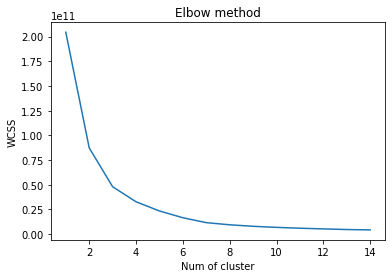

In [240]:
import matplotlib.pyplot as plt

wcss=[]

for i in range(1,15):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(vector_mean_array)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,15), wcss)
plt.title('Elbow method')
plt.xlabel('Num of cluster')
plt.ylabel('WCSS')
plt.show()

                10    6     12    0     2    14   5    9    17   8    1    11  \
num sentence  1523  1425  1383  1327  1275  762  724  576  538  520  500  489   

               16   7    18   4   15  13  3   
num sentence  410  289  225  160  96  37  19  


<AxesSubplot:>

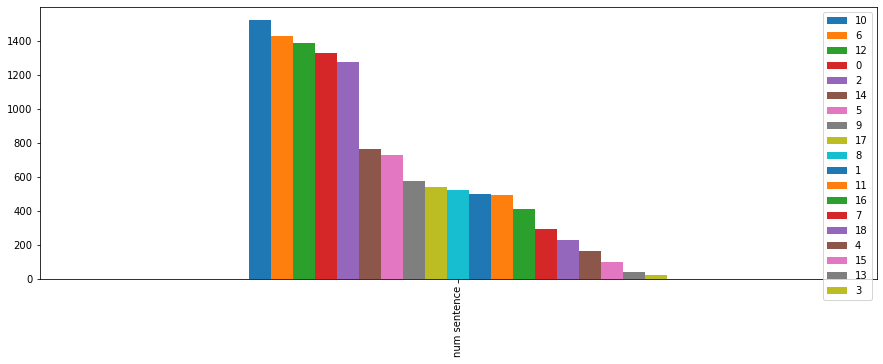

In [241]:
n_cluster=19

clf=KMeans(n_clusters=n_cluster, max_iter=100, init='k-means++', n_init=1)
clf.fit(vector_mean_array)
labels=clf.predict(vector_mean_array)

anzahlen=pd.DataFrame(pd.Series(labels).value_counts(), columns=['num sentence']).T
print(anzahlen)
anzahlen.plot(kind='bar', figsize=(15,5))


In [242]:
def obtain_tsne_graph (X, labels):
    X_embedded=TSNE(n_components=2).fit_transform(X)
    
    df_subset=pd.DataFrame()
    df_subset['tsne1']=X_embedded[:,0]
    df_subset['tsne2']=X_embedded[:,1]
    
    plt.figure(figsize=(16,10))
    sns.scatterplot(x='tsne1', y='tsne2', hue=labels, palette='deep', data=df_subset, legend='full', alpha=0.3)

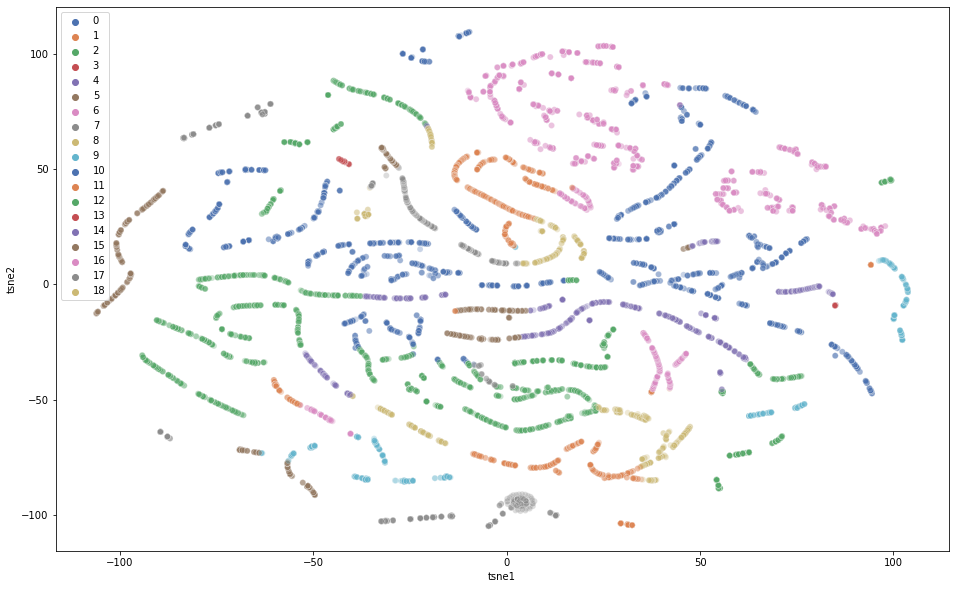

In [243]:
obtain_tsne_graph (vector_mean_array, labels)

In [244]:
labels=list(labels)

In [245]:
len(labels)

12278

In [246]:
df_final['cluster_A'] = labels[6139:]

In [247]:
df_final['cluster_B'] = labels[:6139]

In [170]:
df_final=df_final.merge(data_A[['sentence_A', 'cluster_A']], on='sentence_A')


In [171]:
df_final=df_final.merge(data_A[['sentence_B', 'cluster_B']], on='sentence_B')

In [248]:
for idx, row in df_final.iterrows():
    if row['cluster_A']!=row['cluster_B']:
        df_final['same_cluster']=0
    else:
        df_final['same_cluster']=1

In [255]:
data_B

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_A_dataset,sentence_B_dataset,SemEval_set,sentence_clean
5,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.300,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TEST,group kids playing yard old standing background
6,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,NEUTRAL,3.700,A_neutral_B,B_neutral_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST,young boys playing outdoors smiling nearby
7,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,NEUTRAL,3.000,A_neutral_B,B_contradicts_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST,young boys playing outdoors smiling nearby
9,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,ENTAILMENT,4.900,A_entails_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST,brown attacking another animal front pants
10,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,NEUTRAL,3.665,A_neutral_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST,brown helping another animal front pants
...,...,...,...,...,...,...,...,...,...,...,...,...
9832,9993,A door is being opened by a man,A bald man in a band is playing guitar in the ...,NEUTRAL,1.100,A_neutral_B,B_neutral_A,a man is opening a door,SEMEVAL,FLICKR,TRAIN,bald band playing guitar spotlight
9836,9997,Someone is boiling okra in a pot,The man is not playing the drums,NEUTRAL,1.000,A_neutral_B,B_neutral_A,someone is boiling okra in a pot,SEMEVAL,SEMEVAL,TRAIN,playing drums
9837,9998,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...,NEUTRAL,1.000,A_neutral_B,B_neutral_A,the man sang and played his guitar,SEMEVAL,FLICKR,TRAIN,bicyclist holding bike head group people
9838,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,NEUTRAL,1.200,A_neutral_B,B_neutral_A,a man is jumping rope outside,SEMEVAL,FLICKR,TRAIN,jumping rope outside


In [254]:
df_B

,sentence_clean_B,mean_vector_B,sentence_B
0,group boys yard playing standing background,"[0.6727627, -0.17696868, 0.2732952, -0.0158735...",A group of boys in a yard is playing and a man...
1,brown attacking another animal front tall pants,"[0.7488106, -0.7272957, 0.5976925, 0.20432244,...",A brown dog is attacking another animal in fro...
2,brown attacking another animal front pants,"[0.76807433, -1.1486329, 0.8961909, 0.741039, ...",A brown dog is attacking another animal in fro...
3,two dogs wrestling hugging,"[1.0966573, -2.000752, 1.5271082, 0.7143847, 5...",Two dogs are wrestling and hugging
4,two dogs wrestling hugging,"[1.0966573, -2.000752, 1.5271082, 0.7143847, 5...",Two dogs are wrestling and hugging
...,...,...,...
6134,black brown eyeing insect,"[689.3677, 118.080574, 1220.4855, 354.57785, 1...",A black and brown dog is eyeing an insect
6135,stopping middle road,"[919.2923, 156.89442, 1627.2656, 472.73978, 20...",A man is stopping in the middle of a road
6136,standing dirt hill next black car,"[459.36526, 77.974686, 814.07886, 237.14606, 1...",A man is standing on a dirt hill next to a bla...
6137,rollerblader performing trick ramp,"[689.1997, 117.244705, 1220.027, 355.71048, 15...",A rollerblader is performing a trick on a ramp


In [252]:
df_train_sick.head(10)

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_A_dataset,sentence_B_dataset,SemEval_set
5,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.300,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TEST
6,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,NEUTRAL,3.700,A_neutral_B,B_neutral_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST
7,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,NEUTRAL,3.000,A_neutral_B,B_contradicts_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST
9,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,ENTAILMENT,4.900,A_entails_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST
10,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,NEUTRAL,3.665,A_neutral_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST
12,13,Two dogs are wrestling and hugging,There is no dog wrestling and hugging,CONTRADICTION,3.300,A_contradicts_B,B_contradicts_A,Two dogs wrestle or hug.,FLICKR,FLICKR,TEST
14,15,A brown dog is attacking another animal in fro...,There is no dog wrestling and hugging,NEUTRAL,2.700,A_neutral_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST
15,16,Two dogs are wrestling and hugging,A brown dog is attacking another animal in fro...,NEUTRAL,2.900,A_neutral_B,B_neutral_A,Two dogs wrestle or hug.,FLICKR,FLICKR,TEST
16,17,Two dogs are wrestling and hugging,A brown dog is helping another animal in front...,NEUTRAL,2.300,A_neutral_B,B_neutral_A,Two dogs wrestle or hug.,FLICKR,FLICKR,TEST
18,19,A person in a black jacket is doing tricks on ...,A man in a black jacket is doing tricks on a m...,ENTAILMENT,4.900,A_entails_B,B_entails_A,A person in a black jacket doing tricks on a m...,FLICKR,FLICKR,TEST


In [253]:
df_final.head(10)

,sentence_clean_A,mean_vector_A,sentence_A,sentence_clean_B,mean_vector_B,sentence_B,cluster_A,cluster_B,same_cluster
0,boy playing outdoors smiling,"[0.43800917, 0.1974906, 0.007307589, 0.0369084...",There is no boy playing outdoors and there is ...,group boys yard playing standing background,"[0.6727627, -0.17696868, 0.2732952, -0.0158735...",A group of boys in a yard is playing and a man...,6,6,1
1,group boys yard playing standing background,"[0.6727627, -0.17696868, 0.2732952, -0.0158735...",A group of boys in a yard is playing and a man...,brown attacking another animal front tall pants,"[0.7488106, -0.7272957, 0.5976925, 0.20432244,...",A brown dog is attacking another animal in fro...,6,6,1
2,group children playing house standing background,"[0.9565664, -0.49428, 0.42250443, -0.31214368,...",A group of children is playing in the house an...,brown attacking another animal front pants,"[0.76807433, -1.1486329, 0.8961909, 0.741039, ...",A brown dog is attacking another animal in fro...,6,6,1
3,group children playing house standing background,"[0.9565664, -0.49428, 0.42250443, -0.31214368,...",A group of children is playing in the house an...,two dogs wrestling hugging,"[1.0966573, -2.000752, 1.5271082, 0.7143847, 5...",Two dogs are wrestling and hugging,6,6,1
4,brown attacking another animal front tall pants,"[0.7488106, -0.7272957, 0.5976925, 0.20432244,...",A brown dog is attacking another animal in fro...,two dogs wrestling hugging,"[1.0966573, -2.000752, 1.5271082, 0.7143847, 5...",Two dogs are wrestling and hugging,6,6,1
5,brown attacking another animal front pants,"[0.76807433, -1.1486329, 0.8961909, 0.741039, ...",A brown dog is attacking another animal in fro...,person black jacket tricks motorbike,"[1.450474, -1.8695219, 1.6921282, 0.68909496, ...",A person in a black jacket is doing tricks on ...,6,6,1
6,brown attacking another animal front pants,"[0.76807433, -1.1486329, 0.8961909, 0.741039, ...",A brown dog is attacking another animal in fro...,person black jacket tricks motorbike,"[1.450474, -1.8695219, 1.6921282, 0.68909496, ...",A person in a black jacket is doing tricks on ...,6,6,1
7,brown attacking another animal front pants,"[0.76807433, -1.1486329, 0.8961909, 0.741039, ...",A brown dog is attacking another animal in fro...,person black jacket tricks motorbike,"[1.450474, -1.8695219, 1.6921282, 0.68909496, ...",A person in a black jacket is doing tricks on ...,6,6,1
8,brown attacking another animal front pants,"[0.76807433, -1.1486329, 0.8961909, 0.741039, ...",A brown dog is attacking another animal in fro...,black jacket tricks motorbike,"[2.2247539, -2.5568378, 2.5991824, 0.9752657, ...",A man in a black jacket is doing tricks on a m...,6,6,1
9,two dogs wrestling hugging,"[1.0966573, -2.000752, 1.5271082, 0.7143847, 5...",Two dogs are wrestling and hugging,black jacket tricks motorbike,"[2.2247539, -2.5568378, 2.5991824, 0.9752657, ...",There is no man in a black jacket doing tricks...,6,6,1


In [207]:

pca = PCA(n_components=2)
result = pca.fit_transform(mean_vector_array)
# create a scatter plot of the projection

figure(figsize=(20, 16), dpi=80)
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

NameError: name 'mean_vector_array' is not defined

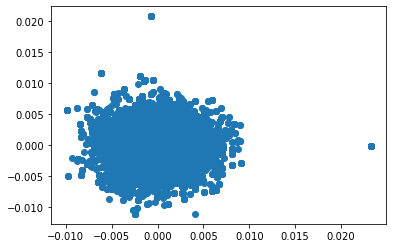

In [138]:

pca = PCA(n_components=2).fit(X)
coords=pca.transform(X)
plt.scatter(coords[:,0],  coords[:,1])
plt.show()

In [111]:
def obtain_cluster_wheel(df_init, clusters_clients):
 
    kats=df_init['origin_sentence'].unique()
 
    #df_final_small= df_final[0:N_length]
 
    categories = kats
 
    fig = go.Figure()
    df_init['cluster'] = clusters_clients
 
    for i in df_init['cluster'].unique():
        cluster_features = df_init[df_init['cluster'] == i]
 
        fig.add_trace(go.Scatterpolar(
          r = [cluster_features[kat].mean() for kat in kats],
          theta=categories,
          fill='toself',
          name='Segment ' + str(i)
      ))
 
    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
      showlegend=True
    )
 
    fig.show()
   
    #fig.write_html("test.html")
   
    return df_init

In [ ]:
sent=df_test_sick['sentence_A'].tolist()

In [25]:
sentences = []

for elem in sent:
    sentences.append(elem.replace(" ", "_"))
    

In [26]:
listquery2Str = ' '.join([str(elem) for elem in sentences])
 
text=re.sub(r"[^.A-Za-z]",' ',listquery2Str)
sentence=text.split('.')
tokens=[nltk.word_tokenize(words) for words in sent]

In [28]:
tokens

[['A', 'man', 'is', 'stopping', 'a', 'horse'],
 ['The', 'man', 'is', 'not', 'riding', 'a', 'horse'],
 ['The', 'man', 'is', 'riding', 'a', 'horse'],
 ['A', 'man', 'is', 'riding', 'a', 'horse'],
 ['A', 'horse', 'is', 'riding', 'over', 'a', 'man'],
 ['A', 'horse', 'is', 'being', 'ridden', 'by', 'a', 'man'],
 ['The', 'person', 'is', 'not', 'drawing'],
 ['A', 'man', 'is', 'drawing', 'a', 'picture'],
 ['The', 'person', 'is', 'not', 'drawing'],
 ['Someone', 'is', 'drawing', 'a', 'person'],
 ['The', 'person', 'is', 'drawing'],
 ['A', 'man', 'is', 'taking', 'a', 'picture', 'of', 'a', 'drawing'],
 ['A', 'man', 'is', 'drawing', 'a', 'picture'],
 ['Someone', 'is', 'beautifully', 'playing', 'the', 'piano'],
 ['Someone', 'is', 'dismantling', 'a', 'piano'],
 ['There', 'is', 'no', 'one', 'playing', 'the', 'guitar'],
 ['Someone', 'is', 'playing', 'a', 'piano'],
 ['Someone', 'is', 'beautifully', 'playing', 'the', 'piano'],
 ['Someone', 'is', 'playing', 'a', 'piano'],
 ['Some', 'food', 'is', 'being', 'ea

In [37]:
model_2 = word2vec.Word2Vec(tokens, size=100, min_count=1, workers=4)

In [30]:
model_2.build_vocab(tokens, progress_per=10000)

RuntimeError: cannot sort vocabulary after model weights already initialized.

In [31]:
model_2.train(tokens, total_examples=model_2.corpus_count, epochs=30, report_delay=1)

(336409, 594180)

In [32]:
vocab = list(model_2.wv.vocab)

In [33]:
my_vocab = {}
for w in tokens:
    my_vocab[w] = model_2.wv.vocab[w]

X = model[my_vocab]
pca.fit_transform(X)

TypeError: unhashable type: 'list'

In [35]:
import pyplot

ModuleNotFoundError: No module named 'pyplot'

<ipython-input-44-592b8e807843>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model_2[model_2.wv.vocab]


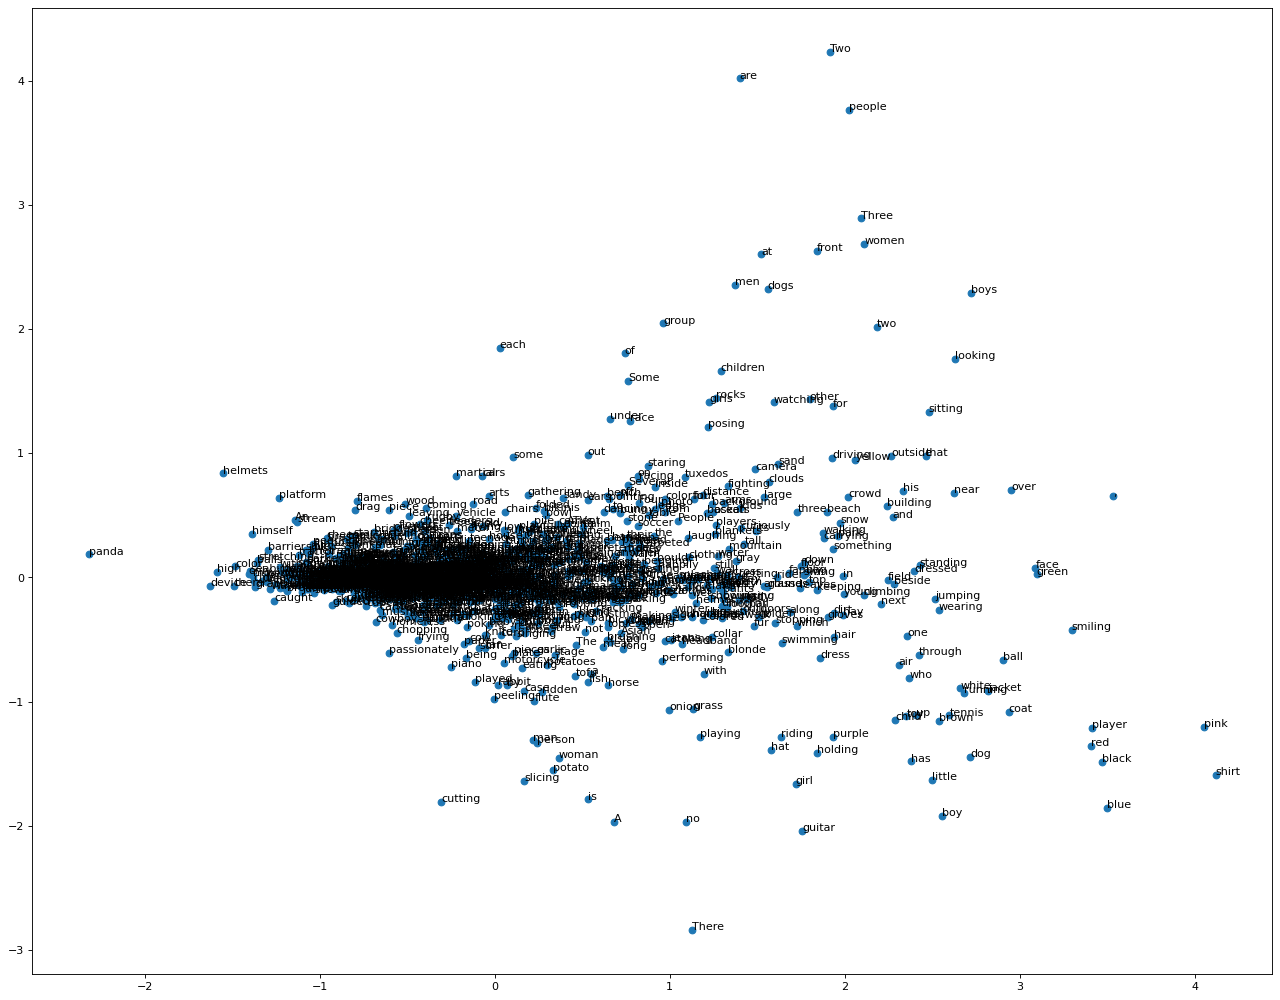

In [44]:
# fit a 2d PCA model to the vectors
X = model_2[model_2.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

figure(figsize=(20, 16), dpi=80)
plt.scatter(result[:, 0], result[:, 1])
words = list(model_2.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [234]:
model_2.init_sims(replace=True)

<ipython-input-234-92fbe671419f>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_2.init_sims(replace=True)


In [235]:
model_2.wv.most_similar('pizza')

[('cheese', 0.9849158525466919),
 ('sprinkling', 0.9831411242485046),
 ('alligator', 0.980039119720459),
 ('patted', 0.9758671522140503),
 ('sausages', 0.9741426706314087),
 ('shredded', 0.9737246036529541),
 ('ramp', 0.9713654518127441),
 ('someone', 0.9690715670585632),
 ('dropped', 0.9668125510215759),
 ('doctor', 0.9662946462631226)]

In [185]:
model_2.wv.most_similar(['a', 'woman', 'is', 'playing'])

[('of', 0.992853581905365),
 ('are', 0.9917856454849243),
 ('dog', 0.9896623492240906),
 ('in', 0.9868097305297852),
 ('the', 0.9863860607147217),
 ('and', 0.9850439429283142),
 ('on', 0.9847042560577393),
 ('man', 0.9843924045562744),
 ('with', 0.9810254573822021),
 ('The', 0.9655666351318359)]

In [ ]:
A man is sprinkling shredded cheese on a pizza',
 'A man is putting seasoning on a pizza',
 'A man is doing a card trick',

In [245]:
similarity_two_words = model_2.wv.similarity(['A', 'man', 'is', 'putting', 'seasoning', 'on', 'a', 'pizza'],
                                             ['A', 'man', 'is', 'sprinkling', 'shredded', 'cheese', 'on', 'a', 'pizza'])
print("Please provide the similarity between these two words:")
print(similarity_two_words)

ValueError: shapes (8,100) and (9,100) not aligned: 100 (dim 1) != 9 (dim 0)

In [246]:
similarity_two_words = model_2.wv.similarity( 'seasoning','sprinkling')
print("Please provide the similarity between these two words:")
print(similarity_two_words)

Please provide the similarity between these two words:
0.93801576


In [239]:
dissimlar_words = model_2.wv.doesnt_match('Someone is beautifully playing the piano'.split())
print(dissimlar_words)

the


In [186]:
model_2.wv.most_similar('woman', topn=30)

[('dog', 0.9971209764480591),
 ('of', 0.9969750642776489),
 ('playing', 0.9958195686340332),
 ('man', 0.9954290986061096),
 ('in', 0.9947142601013184),
 ('on', 0.99430251121521),
 ('and', 0.9939059615135193),
 ('with', 0.9919837713241577),
 ('are', 0.9877668619155884),
 ('a', 0.9874593019485474),
 ('the', 0.9863038063049316),
 ('The', 0.979899525642395),
 ('A', 0.9303878545761108),
 ('is', 0.9142385721206665)]

In [250]:
from lib.sentence2vec import Sentence2Vec

ModuleNotFoundError: No module named 'lib.sentence2vec'

ERROR: Could not find a version that satisfies the requirement lib.sentence2vec
ERROR: No matching distribution found for lib.sentence2vec
Note: you may need to restart the kernel to use updated packages.


 Clustering prediction given a sentence

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy



# vectorization of the texts
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(sent)
# used words (axis in our multi-dimensional space)
words = vectorizer.get_feature_names()
print("words", words)


n_clusters=6
number_of_seeds_to_try=10
max_iter = 300
number_of_process=2 # seads are distributed
model = KMeans(n_clusters=n_clusters, max_iter=max_iter, n_init=number_of_seeds_to_try, n_jobs=number_of_process).fit(X)

labels = model.labels_
# indices of preferible words in each cluster
ordered_words = model.cluster_centers_.argsort()[:, ::-1]

print("centers:", model.cluster_centers_)
print("labels", labels)
print("intertia:", model.inertia_)

texts_per_cluster = numpy.zeros(n_clusters)
for i_cluster in range(n_clusters):
    for label in labels:
        if label==i_cluster:
            texts_per_cluster[i_cluster] +=1 

print("Top words per cluster:")
for i_cluster in range(n_clusters):
    print("Cluster:", i_cluster, "texts:", int(texts_per_cluster[i_cluster])),
    for term in ordered_words[i_cluster, :10]:
        print("\t"+words[term])

print("\n")
print("Prediction")

text_to_predict = "i was riding a horse at the park?"
Y = vectorizer.transform([text_to_predict])
predicted_cluster = model.predict(Y)[0]
texts_per_cluster[predicted_cluster]+=1

print(text_to_predict)
print("Cluster:", predicted_cluster, "texts:", int(texts_per_cluster[predicted_cluster])),
for term in ordered_words[predicted_cluster, :10]:
    print("\t"+words[term])

words ['absent', 'accident', 'acrobatics', 'added', 'adding', 'adults', 'aiming', 'aimlessly', 'air', 'airborne', 'aircraft', 'airplane', 'alligator', 'alongside', 'amazedly', 'american', 'amusedly', 'animal', 'anxiously', 'approaching', 'arcade', 'area', 'aren', 'arm', 'armbands', 'arms', 'arrangement', 'arts', 'asian', 'asleep', 'athletes', 'attached', 'attentively', 'atvs', 'audience', 'away', 'baby', 'background', 'backs', 'bag', 'bale', 'ball', 'balls', 'bamboo', 'banana', 'band', 'bank', 'bare', 'barking', 'barrier', 'bars', 'base', 'baseball', 'basketball', 'baskets', 'bathing', 'battling', 'beach', 'bear', 'bearded', 'beautiful', 'beautifully', 'bed', 'bedroom', 'bee', 'beer', 'beers', 'begging', 'beige', 'belly', 'bench', 'bend', 'bent', 'bib', 'bicycle', 'bicyclist', 'big', 'bike', 'biker', 'bikes', 'bikini', 'bikinis', 'bin', 'bird', 'birdcage', 'biting', 'black', 'blanket', 'blankets', 'block', 'blond', 'blonde', 'blue', 'blurry', 'bmx', 'board', 'boat', 'boiling', 'books',

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"



Cluster: 0 texts: 852
	person
	boy
	people
	child
	playing
	men
	young
	jumping
	wearing
	sitting
Cluster: 1 texts: 101
	playing
	guitar
	man
	piano
	flute
	drums
	singing
	boy
	little
	keyboard
Cluster: 2 texts: 128
	girl
	pink
	hair
	young
	sign
	wearing
	shirt
	beach
	horse
	standing
Cluster: 3 texts: 229
	woman
	slicing
	frying
	cutting
	man
	blue
	riding
	horse
	tofu
	pan
Cluster: 4 texts: 257
	dog
	brown
	running
	ball
	black
	grass
	jumping
	white
	water
	field
Cluster: 5 texts: 433
	man
	riding
	cutting
	horse
	potato
	drawing
	slicing
	standing
	motorcycle
	dancing


Prediction
i was riding a horse at the park?
Cluster: 5 texts: 434
	man
	riding
	cutting
	horse
	potato
	drawing
	slicing
	standing
	motorcycle
	dancing
